In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import scipy
from ast import literal_eval
import json 
import tqdm

In [139]:
rng = np.random.default_rng(6436)

## Code: Simulation

In [140]:
def simulation(params, n, beta=1.0, tmax=100, ts=10, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    beta: capture efficiency, list of length n (per cell) or single value
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # apply capture efficiency: for each count, draw from Binomial(count, beta)
    x1_samples_beta = np.random.binomial(x1_samples, beta).tolist()
    x2_samples_beta = np.random.binomial(x2_samples, beta).tolist()

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))
    samples_beta = list(zip(x1_samples_beta, x2_samples_beta))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    # collect all sample paths: original and observed
    data = {
        'x1_OG': x1_samples,
        'x2_OG': x2_samples,
        'OG': samples,
        'x1_OB': x1_samples_beta,
        'x2_OB': x2_samples_beta,
        'OB': samples_beta
    }

    return data

## Code: Bootstrap (pairwise)

Compute CI's on both marginal and joint distributions of observed counts using pairwise bootstrap resamples

In [141]:
def bootstrap(samples, BS=1000, thresh_OB=10, threshM_OB=10, plot=False, printing=False):

    # sample size
    n = len(samples)

    # compute maximum x1 and x2 values
    M, N = np.max(samples, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [x[1] + (N + 1)*x[0] for x in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(BS, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(BS)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=BS*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts (/n) of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # set truncation bounds
    min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = M, 0, N, 0
    minM_x1_OB, maxM_x1_OB = M, 0
    minM_x2_OB, maxM_x2_OB = N, 0

    # set flag for changes
    thresh_flag = False
    thresh_flag_x1 = False
    thresh_flag_x2 = False

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh_OB:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < min_x1_OB:
                    min_x1_OB = x1
                    thresh_flag = True
                if x2 < min_x2_OB:
                    min_x2_OB = x2
                    thresh_flag = True
                # check if larger than current max
                if x1 > max_x1_OB:
                    max_x1_OB = x1
                    thresh_flag = True
                if x2 > max_x2_OB:
                    max_x2_OB = x2
                    thresh_flag = True

    for x1 in range(M + 1):
        # below: replace
        if x1_sample_counts[x1] < threshM_OB:
            x1_bounds[:, x1] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x1 < minM_x1_OB:
                minM_x1_OB = x1
                thresh_flag_x1 = True
            # check if larger than current max
            if x1 > maxM_x1_OB:
                maxM_x1_OB = x1
                thresh_flag_x1 = True

    for x2 in range(N + 1):
        # below: replace
        if x2_sample_counts[x2] < threshM_OB:
            x2_bounds[:, x2] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x2 < minM_x2_OB:
                minM_x2_OB = x2
                thresh_flag_x2 = True
            # check if larger than current max
            if x2 > maxM_x2_OB:
                maxM_x2_OB = x2
                thresh_flag_x2 = True

    # if no states were above threshold: default to max range, report
    if not thresh_flag:
        min_x1_OB, max_x1_OB, min_x2_OB, max_x2_OB = 0, M, 0, N
    if not thresh_flag_x1:
        minM_x1_OB, maxM_x1_OB = 0, M
    if not thresh_flag_x2:
        minM_x2_OB, maxM_x2_OB = 0, N

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= min_x1_OB) and (x2 >= min_x2_OB) and (x1 <= max_x1_OB) and (x2 <= max_x2_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            # within truncation: green CI lines
            if (x1 >= minM_x1_OB) and (x1 <= maxM_x1_OB):
                color = "green"
            else:
                color = "red"
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color=color)
            axs[x1].axvline(x1_bounds[1, x1], color=color)

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            # within truncation: green CI lines
            if (x2 >= minM_x2_OB) and (x2 <= maxM_x2_OB):
                color = "green"
            else:
                color = "red"
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color=color)
            axs[x2].axvline(x2_bounds[1, x2], color=color)

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    if printing:
        print(f"Box truncation: [{min_x1_OB}, {max_x1_OB}] x [{min_x2_OB}, {max_x2_OB}]")
        print(f"Marginal x1 truncation: [{minM_x1_OB}, {maxM_x1_OB}]")
        print(f"Marginal x2 truncation: [{minM_x2_OB}, {maxM_x2_OB}]")

    results =  {
        'samples': samples,
        'sample_counts': sample_counts,
        'sample_counts_x1': x1_sample_counts,
        'sample_counts_x2': x2_sample_counts,
        'joint': bounds,
        'x1': x1_bounds,
        'x2': x2_bounds,
        'min_x1_OB': min_x1_OB,
        'max_x1_OB': max_x1_OB,
        'min_x2_OB': min_x2_OB,
        'max_x2_OB': max_x2_OB,
        'minM_x1_OB': minM_x1_OB,
        'maxM_x1_OB': maxM_x1_OB,
        'minM_x2_OB': minM_x2_OB,
        'maxM_x2_OB': maxM_x2_OB,
        'thresh_flag': thresh_flag,
        'thresh_flag_x1': thresh_flag_x1,
        'thresh_flag_x2': thresh_flag_x2
    }

    return results

# Marginal Optimization

Investigate using marginal bounds and constraints under the hypothesis of no interaction

Compare performance of these changes to correlation tests

### New method: separate optimizations

Bootstrap to compute CI bounds on the observed marginal distribution of $X_{1}$ and $X_{2}$ counts. For each use univaraite B-matrix and CME constraints with $k_{reg} = 0$ and $k_{deg} = 1$ fixed to test feasibility. 

### Existing method

Bootstrap to compute CI bounds on the observed joint distribution, then use bivariate B-matrix and CME constraints with the original joint distribution factorised into a product of marginals (as variables) and fixing $k_{reg} = 0$ and $k_{deg_{1}} = k_{deg_{2}} = 1$

However, CI bounds on observed marginals can also be computed, and univariate B-matrix and CME constraints added


## Code: Joint and Marginal Truncations

In [142]:
def B(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j): product of binomials.'''
    # currently just work with float beta

    return scipy.stats.binom.pmf(x1_OB, x1_OG, beta) * scipy.stats.binom.pmf(x2_OB, x2_OG, beta)

In [143]:
def BM(x_OB, x_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X_OB | X_OG, Beta_j): binomial prob.'''
    # currently just work with float beta

    return scipy.stats.binom.pmf(x_OB, x_OG, beta)

In [144]:
def findTrunc_old(x1_OB, x2_OB, beta, thresh_OG):
    '''
    Compute box truncation around states (x1_OG, x2_OG) which have
    B(x1_OB, x2_OB, x1_OG, x2_OG, beta) >= thresh_OG

    returns: min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG
    '''

    trunc_start = False
    trunc_end = False
    min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG = np.inf, 0, np.inf, 0
    diag = 0
    while (not trunc_start) or (not trunc_end):

        # start at top of grid
        x1_OG = x1_OB
        x2_OG = x2_OB + diag

        # flag if at least one coeff > thresh in diagonal
        trunc_diag = False

        # compute coeffs along diagonal
        while x2_OG >= x2_OB:

            # compute coeff
            coeff = B(x1_OB, x2_OB, x1_OG, x2_OG, beta)

            # above thresh
            if coeff >= thresh_OG:

                # update truncations
                if x1_OG < min_x1_OG:
                    min_x1_OG = x1_OG
                if x2_OG < min_x2_OG:
                    min_x2_OG = x2_OG
                if x1_OG > max_x1_OG:
                    max_x1_OG = x1_OG
                if x2_OG > max_x2_OG:
                    max_x2_OG = x2_OG

                # at least one coeff > thresh (overall)
                trunc_start = True

                # at least one coeff > thresh (in diag)
                trunc_diag = True

            # move down diagonal
            x2_OG -= 1
            x1_OG += 1

        # if NO coeff > thresh (in diag) AND at least one coeff > thresh (overall)
        if (not trunc_diag) and trunc_start:

            # end
            trunc_end = True

        # increment diagonal
        diag += 1

    return min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG

In [145]:
def findTrunc(x1_OB, x2_OB, beta, thresh_OG):
    '''
    Compute box truncation around states (x1_OG, x2_OG) which have
    B(x1_OB, x2_OB, x1_OG, x2_OG, beta) >= thresh_OG

    returns: m_OG, M_OG, n_OG, N_OG
    '''

    trunc_start = False
    trunc_end = False
    m_OG, M_OG, n_OG, N_OG = np.inf, 0, np.inf, 0
    diag = 0
    while (not trunc_start) or (not trunc_end):

        # flag if at least one coeff > thresh in diagonal
        trunc_diag = False

        # diagonal from upper right to lower left
        x1_OG_diag = np.array([x1_OB + i for i in range(diag + 1)])
        x2_OG_diag = np.array([x2_OB + diag - i for i in range(diag + 1)])

        # compute coeffs
        coeffs = scipy.stats.binom.pmf(x1_OB, x1_OG_diag, beta) * scipy.stats.binom.pmf(x2_OB, x2_OG_diag, beta)

        # find where above threshold
        idxs = np.argwhere(coeffs > 10**-6).reshape(-1)

        # if any values above threshold
        if idxs.size > 0:

            # at least one coeff > thresh (overall)
            trunc_start = True

            # at least one coeff > thresh (in diag)
            trunc_diag = True

            # find states above threshold
            x1_states = x1_OG_diag[idxs]
            x2_states = x2_OG_diag[idxs]

            # find boundaries
            min_x1 = min(x1_states)
            min_x2 = min(x2_states)
            max_x1 = max(x1_states)
            max_x2 = max(x2_states)

            # update truncations
            if min_x1 < m_OG:
                m_OG = min_x1
            if min_x2 < n_OG:
                n_OG = min_x2
            if max_x1 > M_OG:
                M_OG = max_x1
            if max_x2 > N_OG:
                N_OG = max_x2

        # if NO coeff > thresh (in diag) AND at least one coeff > thresh (overall)
        if (not trunc_diag) and trunc_start:

            # end
            trunc_end = True

        # increment diagonal
        diag += 1

    return int(m_OG), int(M_OG), int(n_OG), int(N_OG)

In [146]:
def findTruncM(x_OB, beta, threshM_OG):
    '''
    Compute interval truncation of states x_OG which have
    B(x_OB, x_OG, beta) >= threshM_OG
    
    returns: minM_OG, maxM_OG
    '''

    # start at first non-zero coefficient
    x_OG = x_OB
    coeff = BM(x_OB, x_OG, beta)

    # if not above threshold: increment until above
    while coeff < threshM_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = BM(x_OB, x_OG, beta)

    # store first state coeff >= thresh
    minM_OG = x_OG

    # increment until below threshold
    while coeff >= threshM_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = BM(x_OB, x_OG, beta)

    # store last state with coeff >= thresh (INCLUSIVE BOUND)
    maxM_OG = x_OG - 1

    return minM_OG, maxM_OG

In [147]:
def preComputeTruncation(M, beta, thresh_OG):
    '''
    Compute dict of original truncations

    M: max state of observed pairs that truncations are computed for
    beta: capture efficiency vector
    thresh_OG: threshold for trunction
    '''
    # store in dictionary (lookup table)
    truncations = {}

    # for each pair of observed counts
    for x1_OB in tqdm.tqdm(range(M + 1)):
        for x2_OB in range(x1_OB + 1):

            # compute truncation bounds
            min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG = findTrunc(x1_OB, x2_OB, beta, thresh_OG)

            # store
            truncations[f'({x1_OB}, {x2_OB})'] = (min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG)

            # store symmetric version
            truncations[f'({x2_OB}, {x1_OB})'] = (min_x2_OG, max_x2_OG, min_x1_OG, max_x1_OG)

    return truncations

In [148]:
def preComputeTruncationM(M, beta, threshM_OG):
    '''
    Compute dict of original truncations

    M: max observed state that truncations are computed for
    beta: capture efficiency vector
    threshM_OG: threshold for trunction
    '''
    # store in dictionary (lookup table)
    truncations = {}

    # for each pair of observed counts
    for x_OB in tqdm.tqdm(range(max)):

            # compute truncation bounds
            minM_OG, maxM_OG = findTruncM(x_OB, beta, threshM_OG)

            # store
            truncations[f'{x_OB}'] = (minM_OG, maxM_OG)

    return truncations

## Code: Separate Optimizations

In [149]:
def optimization_hyp_single(bounds, beta, truncationsM, gene, K=100, silent=True,
                     print_solution=True, print_truncation=True, threshM_OG=10**-6,
                     time_limit=300):

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency-hyp')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # State space truncations

    # marginal observed truncation
    min_OB = bounds[f'minM_x{gene}_OB']
    max_OB = bounds[f'maxM_x{gene}_OB']

    # original truncations: find largest original states needed (to define variables)
    overall_min_OG, overall_max_OG = np.inf, 0

    # for each marginal state used
    for x_OB in range(min_OB, max_OB + 1):

        try:
            # lookup original truncation
            min_OG, max_OG = truncationsM[f'{x_OB}']

        except KeyError:
            # compute if not available
            min_OG, max_OG = findTruncM(x_OB, beta, threshM_OG)

            # store
            truncationsM[f'{x_OB}'] = (min_OG, max_OG)

        # update overall min and max
        if max_OG > overall_max_OG:
            overall_max_OG = max_OG
        if min_OG < overall_min_OG:
            overall_min_OG = min_OG
    
    if print_truncation:
        print(f"Observed counts: [{min_OB}, {max_OB}]")
        print(f"Original counts: [{overall_min_OG}, {overall_max_OG}]")

    # variables

    # marginal stationary distributions: original counts (size = largest original state + 1)
    p = md.addMVar(shape=(overall_max_OG + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    '''aggressive presolve to hopefully ensure this'''
    md.Params.Presolve = 2

    # reaction rate constants
    rate_names = ['k_tx', 'k_deg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # fix k_deg_1 = 1 for identifiability
    md.addConstr(rates['k_deg'] == 1)

    # distributional constraints
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # marginal stationary distribution bounds: for each observed count
    for x_OB in range(min_OB, max_OB + 1):

        # original truncation: lookup from pre-computed dict
        min_OG, max_OG = truncationsM[f'{x_OB}']

        # sum over truncation range (INCLUSIVE)
        sum_expr = gp.quicksum([BM(x_OB, x_OG, beta) * p[x_OG] for x_OG in range(min_OG, max_OG + 1)])

        md.addConstr(sum_expr >= bounds[f'x{gene}'][0, x_OB], name=f"B marginal lb {x_OB}")
        md.addConstr(sum_expr <= bounds[f'x{gene}'][1, x_OB], name=f"B marginal ub {x_OB}")

    # CME
    for x_OG in range(overall_max_OG):
        if x_OG == 0:
            x_zero = 0
        else:
            x_zero = 1

        md.addConstr(
            rates['k_tx'] * x_zero * p[x_OG - 1] + \
            rates['k_deg'] * (x_OG + 1) * p[x_OG + 1] - \
            (rates['k_tx'] + rates['k_deg'] * x_OG) * p[x_OG] == 0,
            name=f"Marginal CME {x_OG}"
        )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'status': None,
        'k_tx': "v",
        'k_deg': 1
    }

    # testing feasibility: simply optimize 0
    md.setObjective(0, GRB.MINIMIZE)

    # set parameter (prevents 'infeasible or unbounded' ambiguity)
    md.Params.DualReductions = 0

    # set solution limit (stop after finding 1 feasible solution)
    md.Params.SolutionLimit = 1

    try:
        md.optimize()
        status_code = md.status
    except:
        status_code = md.status

    # store result
    solution['status'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == "status":
                print(f"Model is {val}")
            elif val == "v":
                print(f"{key} variable")
            else:
                print(f"{key} = {val}")

    # save runtime
    solution['time'] = md.Runtime

    return solution

## Code: Existing method with options

In [150]:
def optimization_hyp(bounds, beta, truncations, truncationsM, K=100, silent=True,
                     print_solution=True, print_truncation=True, thresh_OG=10**-6, threshM_OG=10**-6,
                     time_limit=300, settings={}):

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency-hyp')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # State space truncations

    # observed truncations: computed during bootstrap
    min_x1_OB = bounds['min_x1_OB']
    max_x1_OB = bounds['max_x1_OB']
    min_x2_OB = bounds['min_x2_OB']
    max_x2_OB = bounds['max_x2_OB']

    # marginal observed truncations
    minM_x1_OB = bounds['minM_x1_OB']
    maxM_x1_OB = bounds['maxM_x1_OB']
    minM_x2_OB = bounds['minM_x2_OB']
    maxM_x2_OB = bounds['maxM_x2_OB']

    # original truncations: find largest original states needed (to define variables)
    overall_min_x1_OG, overall_max_x1_OG, overall_min_x2_OG, overall_max_x2_OG = np.inf, 0, np.inf, 0
    #overall_minM_x1_OG, overall_maxM_x1_OG = np.inf, 0
    #overall_minM_x2_OG, overall_maxM_x2_OG = np.inf, 0

    # for each pair of observed states used
    for x1_OB in range(min_x1_OB, max_x1_OB + 1):
        for x2_OB in range(min_x2_OB, max_x2_OB + 1):

            try:
                # lookup original truncation
                min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG = truncations[f'({x1_OB}, {x2_OB})']

            except KeyError:
                # compute if not available
                min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG = findTrunc(x1_OB, x2_OB, beta, thresh_OG)

                # store
                truncations[f'({x1_OB}, {x2_OB})'] = (min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG)

            # if larger than current maximum states: update
            if max_x1_OG > overall_max_x1_OG:
                overall_max_x1_OG = max_x1_OG
            if max_x2_OG > overall_max_x2_OG:
                overall_max_x2_OG = max_x2_OG

            # if smaller than current minimum states: update
            if min_x1_OG < overall_min_x1_OG:
                overall_min_x1_OG = min_x2_OG
            if min_x2_OG < overall_min_x2_OG:
                overall_min_x2_OG = min_x2_OG

    # for each x1 marginal state used
    for x1_OB in range(minM_x1_OB, maxM_x1_OB + 1):

        try:
            # lookup original truncation
            minM_x1_OG, maxM_x1_OG = truncationsM[f'{x1_OB}']

        except KeyError:
            # compute if not available
            minM_x1_OG, maxM_x1_OG = findTruncM(x1_OB, beta, threshM_OG)

            # store
            truncationsM[f'{x1_OB}'] = (minM_x1_OG, maxM_x1_OG)

        # update overall min and max
        if maxM_x1_OG > overall_max_x1_OG:
            overall_max_x1_OG = maxM_x1_OG
        if minM_x1_OG < overall_min_x1_OG:
            overall_min_x1_OG = minM_x1_OG

    # for each x2 marginal state used
    for x2_OB in range(minM_x2_OB, maxM_x2_OB + 1):

        try:
            # lookup original truncation
            minM_x2_OG, maxM_x2_OG = truncationsM[f'{x2_OB}']

        except KeyError:
            # compute if not available
            minM_x2_OG, maxM_x2_OG = findTruncM(x2_OB, beta, threshM_OG)

            # store
            truncationsM[f'{x2_OB}'] = (minM_x2_OG, maxM_x2_OG)

        # update overall min and max
        if maxM_x2_OG > overall_max_x2_OG:
            overall_max_x2_OG = maxM_x2_OG
        if minM_x2_OG < overall_min_x2_OG:
            overall_min_x2_OG = minM_x2_OG
    
    if print_truncation:
        print(f"Observed counts: [{min_x1_OB}, {max_x1_OB}] x [{min_x2_OB}, {max_x2_OB}]")
        print(f"Original counts: [{overall_min_x1_OG}, {overall_max_x1_OG}] x [{overall_min_x2_OG}, {overall_max_x2_OG}]")

    # variables

    # marginal stationary distributions: original counts (size = largest original state + 1)
    p1 = md.addMVar(shape=(overall_max_x1_OG + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
    p2 = md.addMVar(shape=(overall_max_x2_OG + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

    # dummy joint variable to avoid triple products (as not supported by GUROBI): should be removed by presolve
    p_dummy = md.addMVar(shape=(overall_max_x1_OG + 1, overall_max_x2_OG + 1), vtype=GRB.CONTINUOUS, name="p_dummy", lb=0, ub=1)

    '''aggressive presolve to hopefully ensure this'''
    md.Params.Presolve = 2

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # fix k_deg_1 = 1, k_deg = 2 for identifiability
    md.addConstr(rates['k_deg_1'] == 1)
    md.addConstr(rates['k_deg_2'] == 1)

    # distributional constraints
    md.addConstr(p1.sum() <= 1, name="Distribution x1")
    md.addConstr(p2.sum() <= 1, name="Distribution x2")

    if settings['bivariateB']:

        # stationary distribution bounds: for each observed count pair
        for x1_OB in range(min_x1_OB, max_x1_OB + 1):
            for x2_OB in range(min_x2_OB, max_x2_OB + 1):
                
                # original truncation: lookup from pre-computed dict
                min_x1_OG, max_x1_OG, min_x2_OG, max_x2_OG = truncations[f'({x1_OB}, {x2_OB})']
                
                # sum over truncation range (INCLUSIVE): drop terms with coefficients < thresh
                sum_expr = gp.quicksum([
                    B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p1[x1_OG] * p2[x2_OG]
                    for x1_OG in range(min_x1_OG, max_x1_OG + 1)
                    for x2_OG in range(min_x2_OG, max_x2_OG + 1)
                    if B(x1_OB, x2_OB, x1_OG, x2_OG, beta) >= thresh_OG
                ])
                
                md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
                md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")
    
    if settings['univariateB']:

        # marginal stationary distribution bounds: for each observed count
        for x1_OB in range(minM_x1_OB, maxM_x1_OB + 1):

            # original truncation: lookup from pre-computed dict
            minM_x1_OG, maxM_x1_OG = truncationsM[f'{x1_OB}']

            # sum over truncation range (INCLUSIVE)
            sum_expr = gp.quicksum([BM(x1_OB, x1_OG, beta) * p1[x1_OG] for x1_OG in range(minM_x1_OG, maxM_x1_OG + 1)])

            md.addConstr(sum_expr >= bounds['x1'][0, x1_OB], name=f"B marginal lb {x1_OB}")
            md.addConstr(sum_expr <= bounds['x1'][1, x1_OB], name=f"B marginal ub {x1_OB}")

        for x2_OB in range(minM_x2_OB, maxM_x2_OB + 1):

            # original truncation: lookup from pre-computed dict
            minM_x2_OG, maxM_x2_OG = truncationsM[f'{x2_OB}']

            # sum over truncation range (INCLUSIVE)
            sum_expr = gp.quicksum([BM(x2_OB, x2_OG, beta) * p2[x2_OG] for x2_OG in range(minM_x2_OG, maxM_x2_OG + 1)])

            md.addConstr(sum_expr >= bounds['x2'][0, x2_OB], name=f"B marginal lb {x2_OB}")
            md.addConstr(sum_expr <= bounds['x2'][1, x2_OB], name=f"B marginal ub {x2_OB}")

    if settings['bivariateCME']:

        # equate dummy joint variable to product of marginals: all original states
        for x1_OG in range(overall_max_x1_OG + 1):
            for x2_OG in range(overall_max_x2_OG + 1):

                md.addConstr(p_dummy[x1_OG, x2_OG] == p1[x1_OG] * p2[x2_OG], name=f"Dummy joint definition {x1_OG}, {x2_OG}")

        # CME: use dummy joint variable to avoid triple products: k_[] * p1[] * p2[]
        for x1_OG in range(overall_max_x1_OG):
            for x2_OG in range(overall_max_x2_OG):

                # remove terms when x's = 0 as not present in equation
                if x1_OG == 0:
                    x1_zero = 0
                else:
                    x1_zero = 1
                if x2_OG == 0:
                    x2_zero = 0
                else:
                    x2_zero = 1

                md.addConstr(
                    rates['k_tx_1'] * x1_zero * p_dummy[x1_OG - 1, x2_OG] + \
                    rates['k_tx_2'] * x2_zero * p_dummy[x1_OG, x2_OG - 1] + \
                    rates['k_deg_1'] * (x1_OG + 1) * p_dummy[x1_OG + 1, x2_OG] + \
                    rates['k_deg_2'] * (x2_OG + 1) * p_dummy[x1_OG, x2_OG + 1] - \
                    (rates['k_tx_1'] + rates['k_tx_2'] + \
                    rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG) * p_dummy[x1_OG, x2_OG] == 0,
                    name=f"CME {x1_OG}, {x2_OG}"
                    )
    
    if settings['univariateCME']:

        # CME for x1
        for x1_OG in range(overall_max_x1_OG):
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1

            md.addConstr(
                rates['k_tx_1'] * x1_zero * p1[x1_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p1[x1_OG + 1] - \
                (rates['k_tx_1'] + rates['k_deg_1'] * x1_OG) * p1[x1_OG] == 0,
                name=f"Marginal CME x1 {x1_OG}"
            )

        # CME for x2
        for x2_OG in range(overall_max_x2_OG):
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                rates['k_tx_2'] * x2_zero * p2[x2_OG - 1] + \
                rates['k_deg_2'] * (x2_OG + 1) * p2[x2_OG + 1] - \
                (rates['k_tx_2'] + rates['k_deg_2'] * x2_OG) * p2[x2_OG] == 0,
                name=f"Marginal CME x2 {x2_OG}"
            )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'status': None,
        'k_tx_1': "v",
        'k_tx_2': "v",
        'k_deg_1': 1,
        'k_deg_2': 1
    }

    # testing feasibility: simply optimize 0
    md.setObjective(0, GRB.MINIMIZE)

    # set parameter (prevents 'infeasible or unbounded' ambiguity)
    md.Params.DualReductions = 0

    # set solution limit (stop after finding 1 feasible solution)
    md.Params.SolutionLimit = 1

    try:
        md.optimize()
        status_code = md.status
    except:
        status_code = md.status

    # store result
    solution['status'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == "status":
                print(f"Model is {val}")
            elif val == "v":
                print(f"{key} variable")
            else:
                print(f"{key} = {val}")

    # save runtime
    solution['time'] = md.Runtime

    return solution

## Test: interaction detection

See that joint bounds can outperform marginal bounds, detecting lower interaction strengths

In [159]:
# set parameters
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0.375
}

n = 5000
beta = 0.5

# simulate sample
samples = simulation(params, n=n, beta=beta)

In [160]:
# compute truncations
truncations = {}
truncationsM = {}

In [163]:
# bootstrap CI bounds
bounds = bootstrap(samples['OB'], BS=n, thresh_OB=10, threshM_OB=10, plot=False, printing=True)

Box truncation: [0, 3] x [0, 3]
Marginal x1 truncation: [0, 3]
Marginal x2 truncation: [0, 3]


In [164]:
# test x1 feasibility
solution_x1 = optimization_hyp_single(bounds, beta, truncationsM, gene=1, K=100, silent=True,
                     print_solution=True, print_truncation=True, threshM_OG=10**-6,
                     time_limit=300)

Observed counts: [0, 3]
Original counts: [0, 32]
Model is OPTIMAL
k_tx variable
k_deg = 1


In [165]:
# test x2 feasibility
solution_x2 = optimization_hyp_single(bounds, beta, truncationsM, gene=2, K=100, silent=True,
                     print_solution=True, print_truncation=True, threshM_OG=10**-6,
                     time_limit=300)

Observed counts: [0, 3]
Original counts: [0, 32]
Model is OPTIMAL
k_tx variable
k_deg = 1


In [166]:
# test joint feasibility

# constraint settings
settings = {
    'bivariateB': True,
    'univariateB': False,
    'bivariateCME': True,
    'univariateCME': False
}

solution_joint = optimization_hyp(bounds, beta, truncations, truncationsM, K=100, silent=True,
                     print_solution=True, print_truncation=True, thresh_OG=10**-6, threshM_OG=10**-6,
                     time_limit=300, settings=settings)

Observed counts: [0, 3] x [0, 3]
Original counts: [0, 32] x [0, 32]
Model is INFEASIBLE
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1


## Test: false positives

No major issues for either method, although joint bounds are more likely to cause issues due to fewer samples per estimate

In [182]:
# set parameters
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

n = 1000
beta = 0.5

# simulate sample
samples = simulation(params, n=n, beta=beta)

In [183]:
# compute truncations
truncations = {}
truncationsM = {}

In [184]:
# bootstrap CI bounds
bounds = bootstrap(samples['OB'], BS=n, thresh_OB=10, threshM_OB=10, plot=False, printing=True)

Box truncation: [0, 2] x [0, 3]
Marginal x1 truncation: [0, 3]
Marginal x2 truncation: [0, 3]


In [185]:
# test x1 feasibility
solution_x1 = optimization_hyp_single(bounds, beta, truncationsM, gene=1, K=100, silent=True,
                     print_solution=True, print_truncation=True, threshM_OG=10**-6,
                     time_limit=300)

Observed counts: [0, 3]
Original counts: [0, 32]
Model is OPTIMAL
k_tx variable
k_deg = 1


In [186]:
# test x2 feasibility
solution_x2 = optimization_hyp_single(bounds, beta, truncationsM, gene=2, K=100, silent=True,
                     print_solution=True, print_truncation=True, threshM_OG=10**-6,
                     time_limit=300)

Observed counts: [0, 3]
Original counts: [0, 32]
Model is OPTIMAL
k_tx variable
k_deg = 1


In [187]:
# test joint feasibility

# constraint settings
settings = {
    'bivariateB': True,
    'univariateB': True,
    'bivariateCME': True,
    'univariateCME': True
}

solution_joint = optimization_hyp(bounds, beta, truncations, truncationsM, K=100, silent=True,
                     print_solution=True, print_truncation=True, thresh_OG=10**-6, threshM_OG=10**-6,
                     time_limit=300, settings=settings)

Observed counts: [0, 2] x [0, 3]
Original counts: [0, 32] x [0, 32]
Model is OPTIMAL
k_tx_1 variable
k_tx_2 variable
k_deg_1 = 1
k_deg_2 = 1


# Sample Size

Test the effect of sample size on the performance of joint and marginal hyp optimization, and how the results compare to correlation tests:

- do joint and marginals approach similar performance?
- does optimization approach / overtake correlation test performance?

In [280]:
def grid_test():

    # result dictionary
    results = {}

    # fix capture efficiency
    beta = 1.0

    # set truncations
    truncations = {}
    truncationsM = {}

    # grid
    interaction_list = [2, 1, 0.5, 0.1, 0]
    n_list = [100, 500, 1000, 2000, 5000, 10000]

    # max sample size
    n_max = n_list[-1]

    # range of interaction strengths
    for k_reg in interaction_list:

        print(f"k_reg: {k_reg}")

        # set results
        results[k_reg] = {}

        # set parameters
        params_simul = {
            'k_tx_1': 1,
            'k_tx_2': 1,
            'k_deg_1': 1,
            'k_deg_2': 1,
            'k_reg': k_reg
        }

        # simulate large sample
        samples = simulation(params_simul, n=n_max, beta=beta)

        # range of sample sizes up to max
        for n in n_list:

            print(f"n: {n}")

            # slice n samples
            sample = samples['OB'][:n]

            # bootstrap CI bounds
            bounds = bootstrap(sample, BS=n, thresh_OB=10, threshM_OB=10, plot=False, printing=False)

            # test x1 feasibility
            solution_x1 = optimization_hyp_single(bounds, beta, truncationsM, gene=1, K=100, silent=True,
                                print_solution=False, print_truncation=False, threshM_OG=10**-6,
                                time_limit=300)

            # test x2 feasibility
            solution_x2 = optimization_hyp_single(bounds, beta, truncationsM, gene=2, K=100, silent=True,
                                print_solution=False, print_truncation=False, threshM_OG=10**-6,
                                time_limit=300)

            # test joint feasibility

            # constraint settings
            settings = {
                'bivariateB': True,
                'univariateB': True,
                'bivariateCME': True,
                'univariateCME': True
            }

            solution_joint = optimization_hyp(bounds, beta, truncations, truncationsM, K=100, silent=True,
                                print_solution=False, print_truncation=False, thresh_OG=10**-6, threshM_OG=10**-6,
                                time_limit=300, settings=settings)

            # correlation tests
            x1_sample = [x[0] for x in sample]
            x2_sample = [x[1] for x in sample]

            # test
            pearson = scipy.stats.pearsonr(x1_sample, x2_sample)
            spearman = scipy.stats.spearmanr(x1_sample, x2_sample)
            
            # store results
            results[k_reg][n] = {
                'x1': {'status': solution_x1['status'], 'time': solution_x1['time']},
                'x2': {'status': solution_x2['status'], 'time': solution_x2['time']},
                'joint': {'status': solution_joint['status'], 'time': solution_joint['time']},
                'pearson': {'pvalue': float(pearson.pvalue), 'statistic': float(pearson.statistic)},
                'spearman': {'pvalue': float(spearman.pvalue), 'statistic': float(spearman.statistic)}
            }

    return results

In [281]:
# store results
result_list = []

# repeat grid test 5 times
for i in range(5):

    result_list.append(grid_test())

k_reg: 2
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.5
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 2
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.5
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 2
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.5
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 2
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 1
n: 100
n: 500
n: 1000
n: 2000
n: 5000
n: 10000
k_reg: 0.5
n: 100
n: 500
n: 1000
n: 

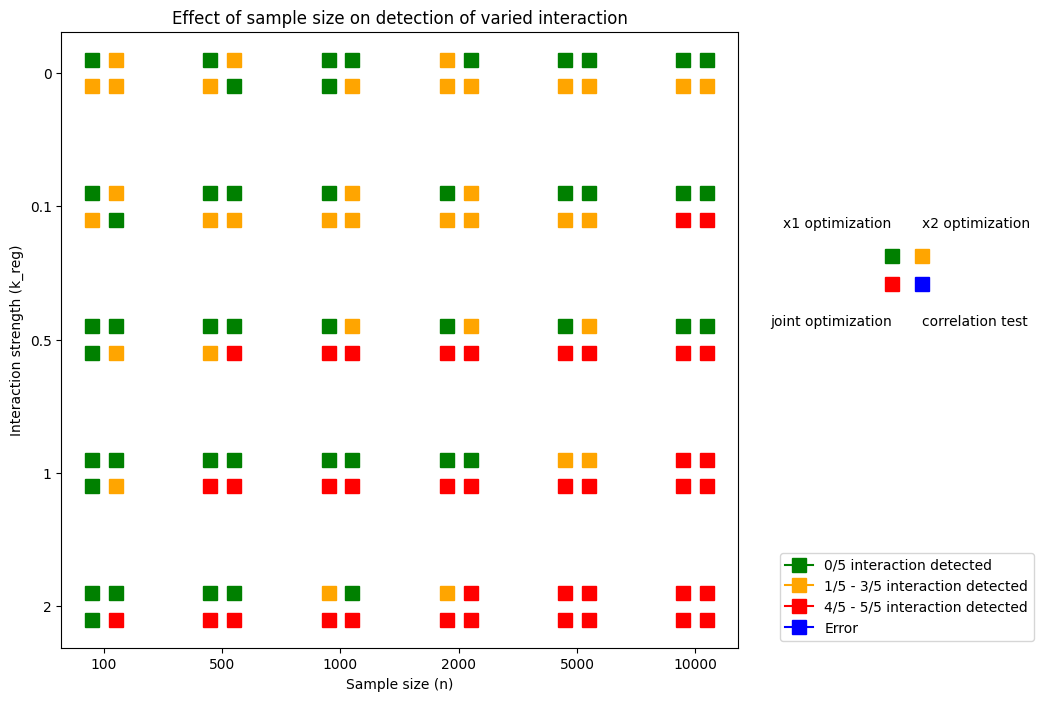

In [347]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8), width_ratios=[4, 1])

# x-axis: sample size
axs[0].set_xlabel("Sample size (n)")
axs[0].set_xticks(range(len(n_list)), labels=n_list)

# y-axis: interaction strength
axs[0].set_ylabel("Interaction strength (k_reg)")
axs[0].set_yticks(range(len(interaction_list)), labels=interaction_list)

offset = 0.1
scale = offset * 100

# plot results
for y, k_reg in enumerate(interaction_list):
    for x, n in enumerate(n_list):

        # x1 top left
        count = 0
        for i in range(5):
            x1_status = result_list[i][k_reg][n]['x1']['status']
            if x1_status == 'INFEASIBLE':
                count += 1
        if count == 0:
            color = "green"
        elif count <= 2:
            color = "orange"
        else:
            color = "red"
        axs[0].plot(x - offset, y + offset, marker="s", color=color, markersize=scale)

        # x2 top right
        count = 0
        for i in range(5):
            x2_status = result_list[i][k_reg][n]['x2']['status']
            if x2_status == 'INFEASIBLE':
                count += 1
        if count == 0:
            color = "green"
        elif count <= 2:
            color = "orange"
        else:
            color = "red"
        axs[0].plot(x + offset, y + offset, marker="s", color=color, markersize=scale)

        # joint bottom left
        count = 0
        for i in range(5):
            joint_status = result_list[i][k_reg][n]['joint']['status']
            if joint_status == 'INFEASIBLE':
                count += 1
        if count == 0:
            color = "green"
        elif count <= 2:
            color = "orange"
        else:
            color = "red"
        axs[0].plot(x - offset, y - offset, marker="s", color=color, markersize=scale)

        # correlation bottom right
        count = 0
        for i in range(5):
            pvalue = result_list[i][k_reg][n]['pearson']['pvalue']
            if pvalue < 0.05:
                count += 1
        if count == 0:
            color = "green"
        elif count <= 3:
            color = "orange"
        else:
            color = "red"
        axs[0].plot(x + offset, y - offset, marker="s", color=color, markersize=scale)

axs[0].set_title("Effect of sample size on detection of varied interaction")

# information panel
axs[1].axis('off')
x, y = 0.5, 0.5
offset = 0.1
scale = 10
axs[1].plot(0, -2)
axs[1].plot(0, 2)
axs[1].plot(1, -2)
axs[1].plot(1, 2)
axs[1].plot(x - offset, y + offset, marker="s", markersize=scale, color="green", label="0/5 interaction detected")
axs[1].text(x - offset, y + 3*offset, "x1 optimization", horizontalalignment='right')
axs[1].plot(x + offset, y + offset, marker="s", markersize=scale, color="orange", label="1/5 - 3/5 interaction detected")
axs[1].text(x + offset, y + 3*offset, "x2 optimization", horizontalalignment='left')
axs[1].plot(x - offset, y - offset, marker="s", markersize=scale, color="red", label="4/5 - 5/5 interaction detected")
axs[1].text(x - offset, y - 4*offset, "joint optimization", horizontalalignment='right')
axs[1].plot(x + offset, y - offset, marker="s", markersize=scale, color="blue", label="Error")
axs[1].text(x + offset, y - 4*offset, "correlation test", horizontalalignment='left')
axs[1].legend(loc="lower center")

plt.show()